# **Sentiment Analysis of IMDB Movie Reviews**

</br>

**Dataset**
</br>

The IMDb Dataset of 50K Movie Reviews, is a popular dataset commonly used for sentiment analysis and natural language processing tasks. The dataset consists of 50,000 movie reviews, with 25,000 reviews labeled as positive and 25,000 as negative
</br>

Dataset Source: [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?datasetId=134715&searchQuery=pytor)
</br>

**The Problem Statement**
</br>

Predict the sentiment (positive or negative) of movie reviews using deep learning techniques.

**Approach Outline:**

- **Data Preprocessing:** Apply preprocessing steps to clean and prepare the text data for analysis. Check the "Data_preprocessing_notebook" for detailed steps.

- **Padding:** Pad the preprocessed text sequences to ensure they have the same length, as deep learning models typically require fixed-length inputs.

- **Word Embedding:** Convert the preprocessed text into a numerical representation using word embeddings (such as Word2Vec ) to represent words as dense vectors in a continuous vector space.

- **Model Training:** Split the dataset into training and test sets and train deep learning models on the training data.

- **Model Selection:** Choose a suitable deep learning model architecture, such as recurrent neural networks (RNNs), long short-term memory (LSTM) networks, or Bidirectional, to build the sentiment analysis model.

- **Model Evaluation:** Evaluate the trained model's performance on the test set, considering metrics such as accuracy, precision, recall,  F1 score an as well as ROC-AUC Curves


**(Initial) Attributes**:

* Review
* Sentiment
 

## All the imports

In [25]:
import gc
gc.collect()

# import to "ignore" warnings

import warnings
warnings.filterwarnings('ignore')

# imports for data manipulation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# import keras (framework for building deep learning models) || need local import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Dense, Dropout , LSTM, SimpleRNN, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GlobalMaxPool1D


# imports from sklearn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import gensim # need local import
from gensim.models import Word2Vec


from keras.utils.vis_utils import plot_model


## Load the csv file 

In [2]:
# read data

data = pd.read_csv('imdb_clean_dataset.csv')
data.head()

review  sentiment
0  one review mention watch oz episod hook right ...          1
1  wonder littl product film techniqu unassum old...          1
2  thought wonder way spend time hot summer weeke...          1
3  basic famili littl boy jake think zombi closet...          0
4  petter mattei love time money visual stun film...          1

## Split Dataset

In [3]:
# Split the dataset into training, validation, and testing sets
X_data, y_data = np.array(data['review']), np.array(data['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42)


print(f'Shape of train data: {X_train.shape}')
print(f'Shape of test data: {X_test.shape}')

Shape of train data: (39665,)
Shape of test data: (9917,)


## Word embedding using Word2Vec model

In [4]:
# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))
Word2vec_train_data

[['realli',
  'like',
  'movi',
  'empor',
  'new',
  'groov',
  'watch',
  'like',
  'come',
  'home',
  'see',
  'wife',
  'relat',
  'llama',
  'serious',
  'movi',
  'bad',
  'like',
  'club',
  'dread',
  'super',
  'trooper',
  'suppos',
  'write',
  'line',
  'even',
  'know',
  'els',
  'say',
  'laugh',
  'coupl',
  'time',
  'drink',
  'movi',
  'like',
  'least',
  'funni',
  'drunk',
  'mayb',
  'llama',
  'funni',
  'regular',
  'cartoon',
  'peopl',
  'either',
  'way',
  'stick',
  'empor',
  'new',
  'groov',
  'want',
  'funni',
  'cartoon',
  'llama',
  'theme',
  'movi',
  'line',
  'line',
  'right'],
 ['decid',
  'watch',
  'movi',
  'note',
  'scariest',
  'movi',
  'ever',
  'expect',
  'unfortun',
  'found',
  'movi',
  'singl',
  'scari',
  'moment',
  'kind',
  'person',
  'jump',
  'easili',
  'movi',
  'noth',
  'terribl',
  'cliché',
  'everi',
  'time',
  'jump',
  'moment',
  'incred',
  'obviou',
  'pro',
  'movi',
  'would',
  'music',
  'odd',
  'scene

In [5]:
# To learn word embeddings specific to the training set, the Word2Vec model is trained on the Word2vec_train_data, 
# which consists of tokenized reviews from the training set. 
# This division ensures a realistic assessment and reduces information leaking from the testing set. 
# The test set is handled as new data, giving a precise evaluation of the model's performance on novel occurrences. 
# Word embeddings are created for the testing data using the trained model.

# refers to the size or length of the vector representation assigned to each word in a word embedding model..
Embedding_dimensions = 100

# Defining the model
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 24221


## Tokenize and Padding

In [6]:
vocab_length = 35000  # Maximum number of words to keep based on their frequency

# Create a tokenizer object
# with filters="", which means no characters will be filtered out during tokenization. 
# The lower=False parameter indicates that the text will not be converted to lowercase. 
# oov_token="<oov>" specifies the out-of-vocabulary token to be used when unseen words are encountered.
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")

tokenizer.fit_on_texts(X_data)  # Fit the tokenizer on the input data to learn the vocabulary based on the provided texts

tokenizer.num_words = vocab_length  # Limit the number of words considered during tokenization

print("Tokenizer vocab length:", vocab_length) 


Tokenizer vocab length: 35000


In [7]:
# Padding is necessary to ensure that all sequences have the same length, which is specified by input_length
# Convert the texts in X_train/X_test into sequences of integers based on the tokenizer's vocabulary. 
# These sequences are then padded using pad_sequences to have a maximum length of input_length

input_length = 750  # The maximum length of the input sequences

# Pad and truncate the sequences in X_train
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)

# Pad and truncate the sequences in X_test
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=input_length)


print("X_train.shape:", X_train.shape)  
print("X_test.shape :", X_test.shape)  
display(X_train)



X_train.shape: (39665, 750)
X_test.shape : (9917, 750)


array([[   0,    0,    0, ...,  117,  117,  112],
       [   0,    0,    0, ...,  301, 1085,  787],
       [   0,    0,    0, ..., 1724,  789, 2163],
       ...,
       [   0,    0,    0, ...,   34,    2,   58],
       [   0,    0,    0, ...,   12, 5600,  704],
       [   0,    0,    0, ...,  973, 1434, 1043]])

## Embedding matrix

In [8]:
# This matrix will be used to store the embedding vectors for each word in the tokenizer's vocabulary.
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

display(tokenizer.word_index.items())

# Iterate over the word-index pairs in the tokenizer's word index
for word, token in tokenizer.word_index.items():
    # Check if the Word2Vec model contains the word
    if word2vec_model.wv.__contains__(word):
        # Retrieve the embedding vector for the word from the Word2Vec model
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape) 
display(embedding_matrix)


dict_items([('<oov>', 1), ('movi', 2), ('film', 3), ('one', 4), ('like', 5), ('time', 6), ('good', 7), ('make', 8), ('charact', 9), ('see', 10), ('get', 11), ('watch', 12), ('even', 13), ('stori', 14), ('would', 15), ('realli', 16), ('well', 17), ('scene', 18), ('look', 19), ('show', 20), ('much', 21), ('end', 22), ('bad', 23), ('great', 24), ('peopl', 25), ('go', 26), ('love', 27), ('also', 28), ('first', 29), ('think', 30), ('act', 31), ('play', 32), ('way', 33), ('thing', 34), ('made', 35), ('could', 36), ('know', 37), ('say', 38), ('seem', 39), ('work', 40), ('plot', 41), ('actor', 42), ('two', 43), ('mani', 44), ('seen', 45), ('year', 46), ('come', 47), ('want', 48), ('take', 49), ('never', 50), ('life', 51), ('best', 52), ('tri', 53), ('littl', 54), ('ever', 55), ('man', 56), ('better', 57), ('give', 58), ('still', 59), ('find', 60), ('perform', 61), ('feel', 62), ('part', 63), ('use', 64), ('someth', 65), ('director', 66), ('actual', 67), ('back', 68), ('lot', 69), ('interest', 

Embedding Matrix Shape: (35000, 100)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.82736796,  0.47283718, -1.69270563, ...,  0.28070807,
         0.90744746, -1.35036922],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Model Selection

##### RNN

In [9]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        SimpleRNN(100,input_shape = (vocab_length,input_length),return_sequences=False,activation="LeakyReLU"),
        Dense(32,activation="relu"),
        Dense(1,activation="sigmoid"),
    ],
    
     name="Sentiment_Model")
    return model


In [10]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 750, 100)          3500000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,523,365
Trainable params: 23,365
Non-trainable params: 3,500,000
_________________________________________________________________


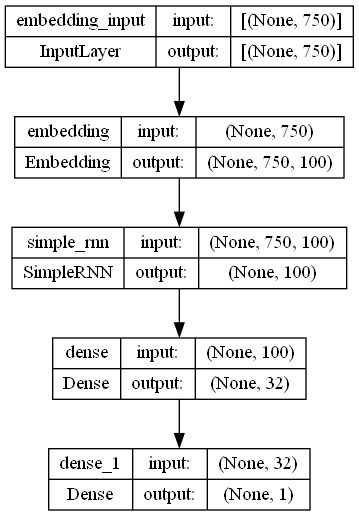

In [41]:
# Plot the model structure
plot_model(training_model, show_shapes=True)

In [11]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]


history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

# Evaluate the model
loss, accuracy = training_model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Epoch 1/10
35/35 [==============================] - 79s 2s/step - loss: 0.6150 - accuracy: 0.6645 - val_loss: 0.5239 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 2/10
35/35 [==============================] - 85s 2s/step - loss: 0.4178 - accuracy: 0.8127 - val_loss: 0.3882 - val_accuracy: 0.8316 - lr: 0.0010
Epoch 3/10
35/35 [==============================] - 81s 2s/step - loss: 0.3615 - accuracy: 0.8435 - val_loss: 0.3555 - val_accuracy: 0.8422 - lr: 0.0010
Epoch 4/10
35/35 [==============================] - 82s 2s/step - loss: 0.3525 - accuracy: 0.8504 - val_loss: 0.3635 - val_accuracy: 0.8457 - lr: 0.0010
Epoch 5/10
35/35 [==============================] - 80s 2s/step - loss: 0.3457 - accuracy: 0.8522 - val_loss: 0.3432 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 6/10
35/35 [==============================] - 89s 3s/step - loss: 0.3337 - accuracy: 0.8589 - val_loss: 0.3440 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 7/10
35/35 [==============================] - 81s 2s/step - loss: 0.3263 - a

### LSTM model

LSTM (Long Short-Term Memory) networks is a type of recurrent neural network (RNN) architecture commonly used for sentiment analysis.

In [13]:
def getModel2():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        LSTM(64,return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1,activation="sigmoid")
    ],
    name="Sentiment_Model_LSTM")
    return model

In [14]:
training_model2 = getModel2()
training_model2.summary()

Model: "Sentiment_Model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 750, 100)          3500000   
                                                                 
 lstm (LSTM)                 (None, 750, 64)           42240     
                                                                 
 dropout (Dropout)           (None, 750, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,554,689
Trainable params: 54,6

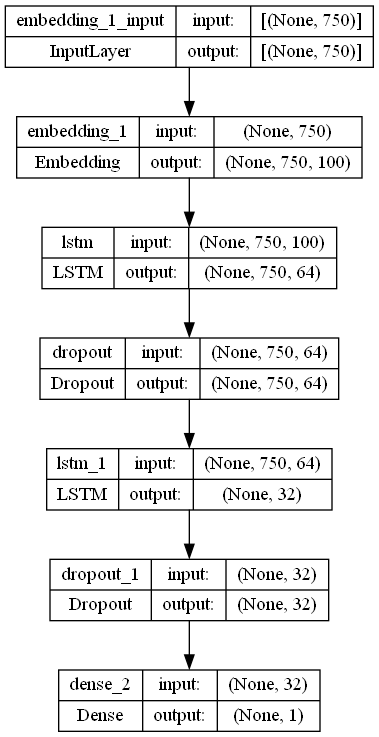

In [40]:
# Plot the model structure
plot_model(training_model2, show_shapes=True)

In [15]:
training_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3)]


history2 = training_model2.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

# Evaluate the model
loss, accuracy = training_model2.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Epoch 1/10
35/35 [==============================] - 222s 6s/step - loss: 0.5149 - accuracy: 0.7438 - val_loss: 0.4010 - val_accuracy: 0.8238 - lr: 0.0010
Epoch 2/10
35/35 [==============================] - 306s 9s/step - loss: 0.3667 - accuracy: 0.8449 - val_loss: 0.3428 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 3/10
35/35 [==============================] - 305s 9s/step - loss: 0.3253 - accuracy: 0.8637 - val_loss: 0.3192 - val_accuracy: 0.8659 - lr: 0.0010
Epoch 4/10
35/35 [==============================] - 259s 7s/step - loss: 0.3056 - accuracy: 0.8725 - val_loss: 0.3340 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 5/10
35/35 [==============================] - 242s 7s/step - loss: 0.3008 - accuracy: 0.8744 - val_loss: 0.3047 - val_accuracy: 0.8687 - lr: 0.0010
Epoch 6/10
35/35 [==============================] - 222s 6s/step - loss: 0.2778 - accuracy: 0.8859 - val_loss: 0.2982 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 7/10
35/35 [==============================] - 209s 6s/step - loss: 0.2

### Bidirectional LSTM

In [20]:
def getModel3():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(35,return_sequences=True)),
        GlobalMaxPool1D(),
        Dense(40, activation="relu"),
        Dropout(0.5),
        Dense(20, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid"),
    ],
    name="Sentiment_Model_LSTM_Bidirectional")
    return model

In [21]:
training_model3 = getModel3()
training_model3.summary()

Model: "Sentiment_Model_LSTM_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 750, 100)          3500000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 750, 70)          38080     
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 70)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 40)                2840      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_4 (Dense)             (No

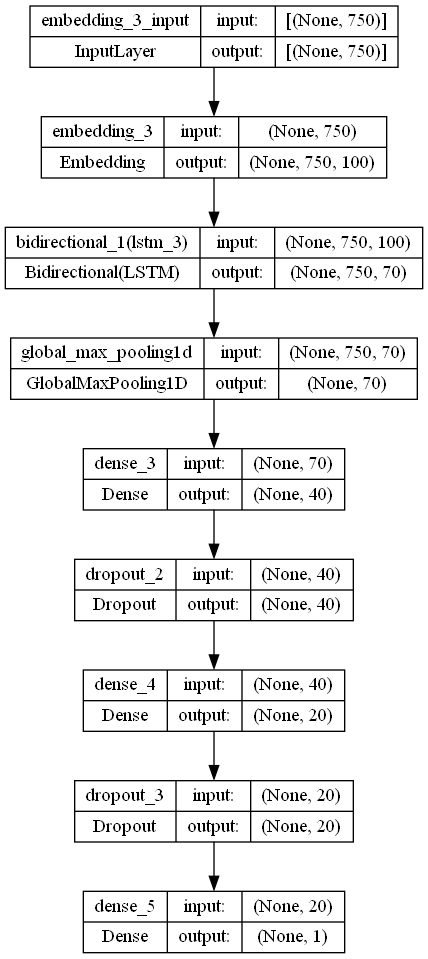

In [42]:
# Plot the model structure
plot_model(training_model3, show_shapes=True)

In [22]:
training_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3)]


history3 = training_model3.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

# Evaluate the model
loss, accuracy = training_model3.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Epoch 1/10
35/35 [==============================] - 155s 4s/step - loss: 0.6664 - accuracy: 0.5823 - val_loss: 0.5674 - val_accuracy: 0.8014 - lr: 0.0010
Epoch 2/10
35/35 [==============================] - 148s 4s/step - loss: 0.5066 - accuracy: 0.7736 - val_loss: 0.3715 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 3/10
35/35 [==============================] - 142s 4s/step - loss: 0.3970 - accuracy: 0.8475 - val_loss: 0.3215 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 4/10
35/35 [==============================] - 142s 4s/step - loss: 0.3520 - accuracy: 0.8693 - val_loss: 0.3015 - val_accuracy: 0.8752 - lr: 0.0010
Epoch 5/10
35/35 [==============================] - 142s 4s/step - loss: 0.3264 - accuracy: 0.8793 - val_loss: 0.2886 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 6/10
35/35 [==============================] - 144s 4s/step - loss: 0.3116 - accuracy: 0.8846 - val_loss: 0.2848 - val_accuracy: 0.8820 - lr: 0.0010
Epoch 7/10
35/35 [==============================] - 159s 5s/step - loss: 0.2

### Plot of training/validation accuracy/loss for each model

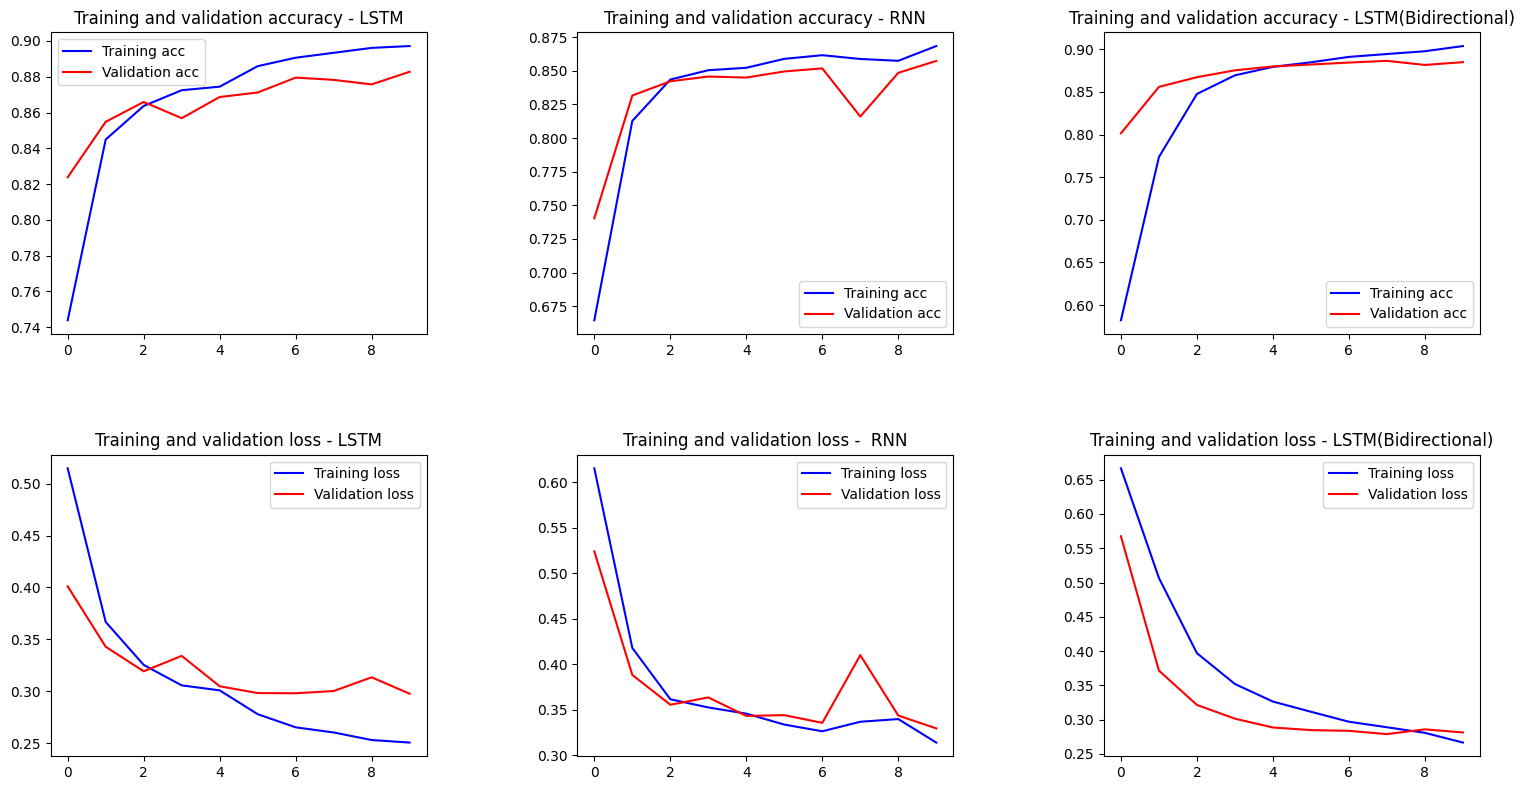

In [26]:
figure , axis = plt.subplots(2,3,figsize=(15,8))
# figure.add_gridspec(2, 2, hspace=10, wspace=10)
# plt.figure(figsize=(8, 6))
acc2,  val_acc2  = history2.history['accuracy'], history2.history['val_accuracy']
loss2, val_loss2 = history2.history['loss'], history2.history['val_loss']
epochs2 = range(len(acc2))
axis[0,0].plot(epochs2, acc2, 'b', label='Training acc')
axis[0,0].plot(epochs2, val_acc2, 'r', label='Validation acc')
axis[0,0].set_title('Training and validation accuracy - LSTM')
axis[0,0].legend()

# plt.figure()

axis[1,0].plot(epochs2, loss2, 'b', label='Training loss')
axis[1,0].plot(epochs2, val_loss2, 'r', label='Validation loss')
axis[1,0].set_title('Training and validation loss - LSTM')
axis[1,0].legend()

# plt.show()

acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

axis[0,1].plot(epochs, acc, 'b', label='Training acc')
axis[0,1].plot(epochs, val_acc, 'r', label='Validation acc')
axis[0,1].set_title('Training and validation accuracy - RNN')
axis[0,1].legend()

# plt.figure()

axis[1,1].plot(epochs, loss, 'b', label='Training loss')
axis[1,1].plot(epochs, val_loss, 'r', label='Validation loss')
axis[1,1].set_title('Training and validation loss -  RNN')
axis[1,1].legend()

acc3,  val_acc3  = history3.history['accuracy'], history3.history['val_accuracy']
loss3, val_loss3 = history3.history['loss'], history3.history['val_loss']
epochs3 = range(len(acc3))
axis[0,2].plot(epochs3, acc3, 'b', label='Training acc')
axis[0,2].plot(epochs3, val_acc3, 'r', label='Validation acc')
axis[0,2].set_title('Training and validation accuracy - LSTM(Bidirectional)')
axis[0,2].legend()

# plt.figure()

axis[1,2].plot(epochs3, loss3, 'b', label='Training loss')
axis[1,2].plot(epochs3, val_loss3, 'r', label='Validation loss')
axis[1,2].set_title('Training and validation loss - LSTM(Bidirectional)')
axis[1,2].legend()

# plt.figure(figsize=(100,100))
figure.tight_layout()
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)

plt.show()

### Confusion Matrix

310/310 [==============================] - 28s 88ms/step


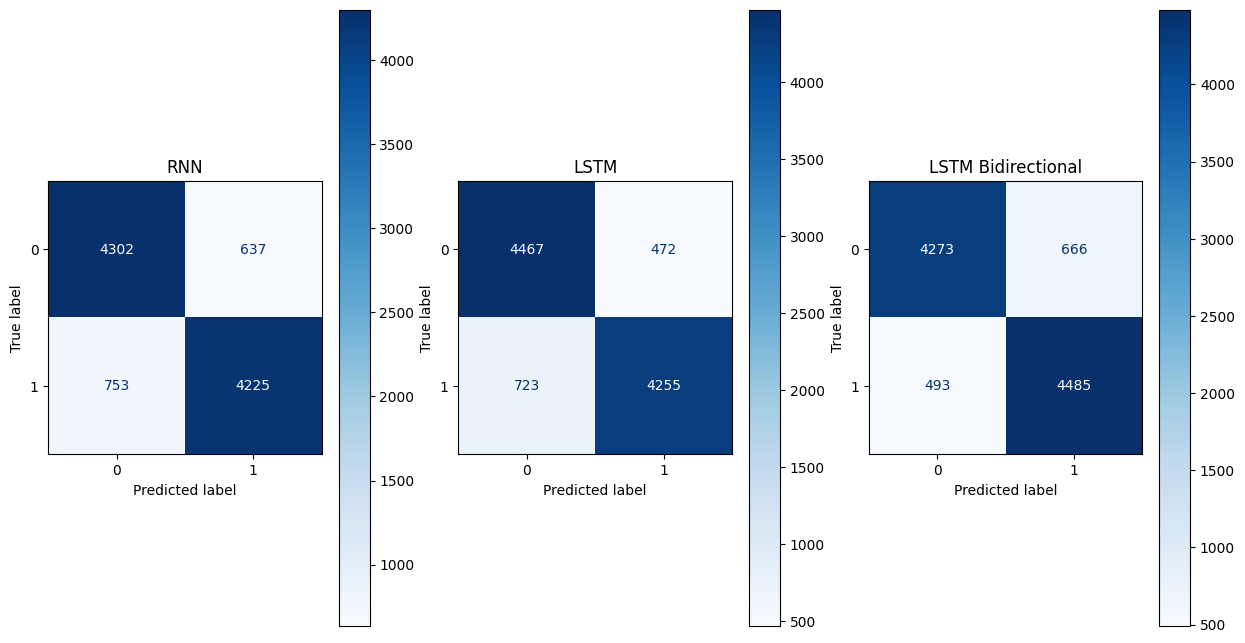

In [27]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay , confusion_matrix
def get_labels(y_pred,y_test):
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    return labels

# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)
y_pred2 = training_model2.predict(X_test)
y_pred3 = training_model3.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)
y_pred2 = np.where(y_pred2>=0.5, 1, 0)
y_pred3 = np.where(y_pred3>=0.5, 1, 0)

l1 = get_labels(y_pred,y_test)
l2 = get_labels(y_pred2,y_test)
l3 = get_labels(y_pred3,y_test)

# Printing out the Evaluation metrics. 
fig, ax = plt.subplots(1,3,figsize=(15,8))
ax[0].set_title("RNN")
ax[1].set_title("LSTM")
ax[2].set_title("LSTM Bidirectional")

ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Blues" ,ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test,y_pred2,cmap="Blues",ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test,y_pred3,cmap="Blues" ,ax = ax[2])

plt.show()


### Classification_report

In [28]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred2))
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4939
           1       0.87      0.85      0.86      4978

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4939
           1       0.90      0.85      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4939
           1       0.87      0.90      0.89      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



### ROC Curves

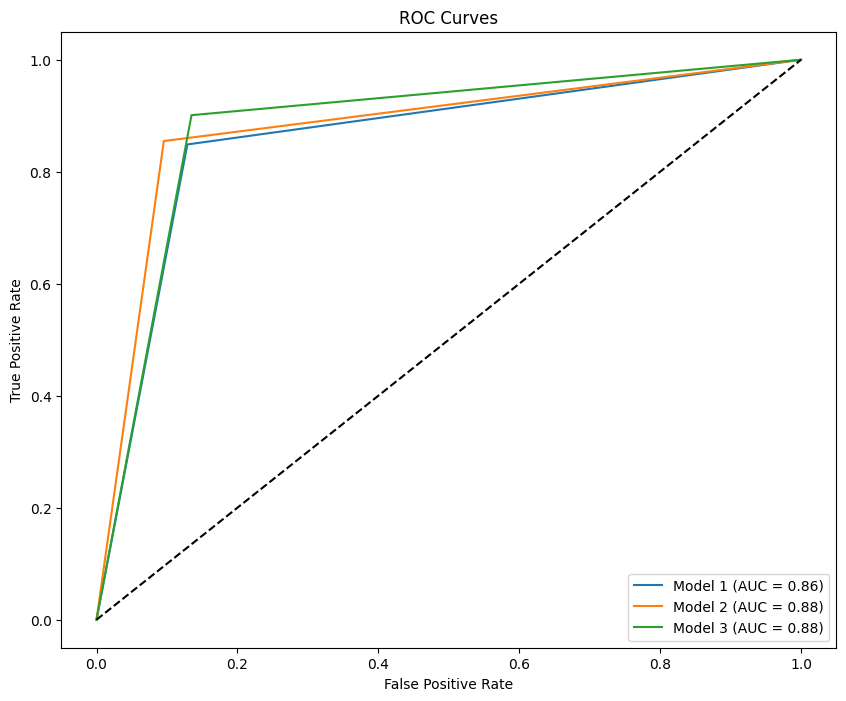

In [31]:
from sklearn.metrics import roc_curve, auc
# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds for each model
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred3)

# Compute the area under the ROC curve (AUC) for each model
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

# Plot the ROC curves for each model
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label='Model 1 (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Model 2 (AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Model 3 (AUC = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()


## Final Winner

**The best model among the three models evaluated is training_model3, which is the LSTM Bidirectional model. It achieved the highest accuracy on the test set compared to the other models, indicating superior performance in sentiment analysis.**

In [39]:
# Evaluate the models and determine the best model
loss1, accuracy1 = training_model.evaluate(X_test, y_test)
loss2, accuracy2 = training_model2.evaluate(X_test, y_test)
loss3, accuracy3 = training_model3.evaluate(X_test, y_test)

if accuracy3 > accuracy1 and accuracy3 > accuracy2:
    print("The best model is model 3 (LSTM Bidirectional).")

310/310 [==============================] - 29s 93ms/step - loss: 0.2857 - accuracy: 0.8831
The best model is model 3 (LSTM Bidirectional).


310/310 [==============================] - 27s 88ms/step


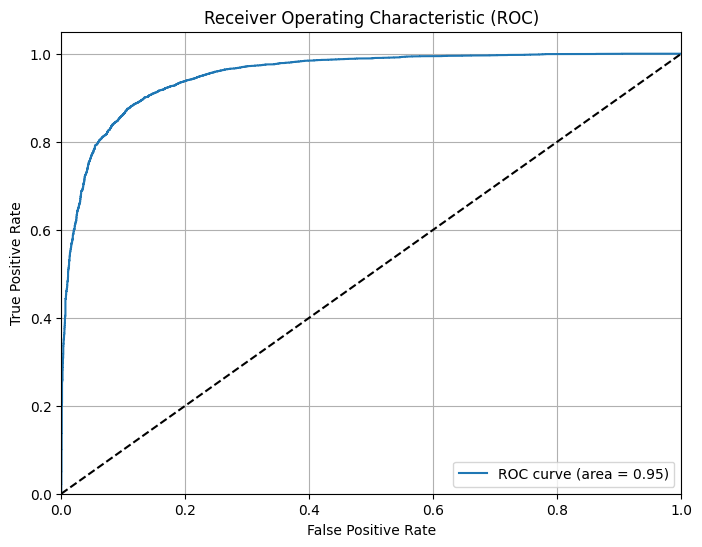

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Generate predictions for the test data
y_pred_prob = training_model3.predict(X_test)

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve
auc = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
